In [109]:
%matplotlib inline
import matplotlib.pyplot as plt

import plotly.graph_objs as go

import pandas as pd
import json
import pickle

import utils

from google.transit import gtfs_realtime_pb2
import datetime, pytz
import requests

In [2]:
pytz.timezone("Australia/Sydney")

<DstTzInfo 'Australia/Sydney' LMT+10:05:00 STD>

## grabbing data from the api

In [108]:
keys = utils.get_keys()

def get_from_api(url=utils.realtime_trip_updates_api, \
                 slug="buses"):
    feed = gtfs_realtime_pb2.FeedMessage()
    headers = {'Authorization': 'apikey ' + keys['nsw_opendata']["api_key"]}
    print("fetching...")
    response = requests.get(url+slug, headers=headers)

    if response.status_code == 200:
        print(f"got {slug} data! from {url[-28:]}")
        feed.ParseFromString(response.content)
        return feed
    else:
        print("failed to get {slug} data")
        print(response.status_code)
        print(response.content)

feed_trip_updates = get_from_api()
feed_realtime_position = get_from_api(url=utils.realtime_positions_api)
feed_timetable = get_from_api(utils.real)

loaded keys for: ['amazon', 'nsw_opendata', 'mapbox']
fetching...
got buses data! from nsw.gov.au/v1/gtfs/realtime/
fetching...
got buses data! from w.gov.au/v1/gtfs/vehiclepos/


so now we have trip updates and real time positions in two seperate feeds - the simpler feed is the positions feed so lets take a look:

## positions feed

- the feed protobuf has entities, each one of which is one thing - in the nsw data its all tripupdates, a few thousand of them.

In [4]:
trip_updates = [e for e in feed_trip_updates.entity if e.HasField('trip_update')]
positions = [e for e in feed_realtime_position.entity if e.HasField("vehicle")]

print(f"Trips: {len(trip_updates)}, Positions: {len(positions)}")

Trips: 2984, Positions: 1773


In [105]:
trip_updates[0]

id: "38743_9477152_2435_827"
trip_update {
  trip {
    trip_id: "709913"
    start_time: "12:26:00"
    start_date: "20180828"
    schedule_relationship: SCHEDULED
    route_id: "2435_827"
  }
  stop_time_update {
    stop_sequence: 1
    arrival {
      delay: 0
      time: 1535423160
    }
    departure {
      delay: 0
      time: 1535423160
    }
    stop_id: "2171449"
    schedule_relationship: SCHEDULED
  }
  stop_time_update {
    stop_sequence: 2
    arrival {
      delay: 0
      time: 1535423280
    }
    departure {
      delay: 0
      time: 1535423280
    }
    stop_id: "2171292"
    schedule_relationship: SCHEDULED
  }
  stop_time_update {
    stop_sequence: 3
    arrival {
      delay: 0
      time: 1535423520
    }
    departure {
      delay: 0
      time: 1535423520
    }
    stop_id: "2171324"
    schedule_relationship: SCHEDULED
  }
  stop_time_update {
    stop_sequence: 4
    arrival {
      delay: 0
      time: 1535423640
    }
    departure {
      delay: 0
   

In [5]:
positions[0]

id: "38743_9477152_2435_827_1"
vehicle {
  trip {
    trip_id: "709913"
    start_time: "12:26:00"
    start_date: "20180828"
    schedule_relationship: SCHEDULED
    route_id: "2435_827"
  }
  position {
    latitude: -33.93595886230469
    longitude: 150.84573364257812
    bearing: 97.0
    speed: 0.0
  }
  timestamp: 1535423012
  congestion_level: UNKNOWN_CONGESTION_LEVEL
  vehicle {
    id: "38743_9477152_2435_827_1"
  }
  occupancy_status: MANY_SEATS_AVAILABLE
}

In [6]:
coords = [(p.vehicle.position.latitude, p.vehicle.position.longitude) for p in positions if p.vehicle.HasField("position")]
lat, long = zip(*coords)
lat[0:2], long[0:2], coords[0:2]

((-33.93595886230469, -33.623138427734375),
 (150.84573364257812, 151.15280151367188),
 [(-33.93595886230469, 150.84573364257812),
  (-33.623138427734375, 151.15280151367188)])

So now we have a bunch of coordinates for all the buses, so lets plot them, using plotly's mapbox integration.

Some learnings:

- if [specifying a symbol](https://community.plot.ly/t/how-to-add-a-custom-symbol-image-inside-map/6641) instead of a point, than can't change the colour. 

In [107]:
data = [
    go.Scattermapbox(
        lat=lat,
        lon=long,
        mode='markers',
        marker=dict(size=9,color="red", opacity=0.5),
        text=["bus "+str(i) for i in range(len(lat))],
    )]

layout = go.Layout(
    autosize=True,
    height=700, width=1000,
    hovermode='closest',
    mapbox=dict(
        accesstoken=keys['mapbox']['token'],
        bearing=0,
        pitch=0,
        zoom=9,
        style="streets",
        center=dict(
            lat=lat[0],
            lon=long[0]
        ),
    ),
)

go.FigureWidget(data=data, layout=layout)

FigureWidget({
    'data': [{'lat': [-33.93595886230469, -33.623138427734375, -34.0782356262207,
             …

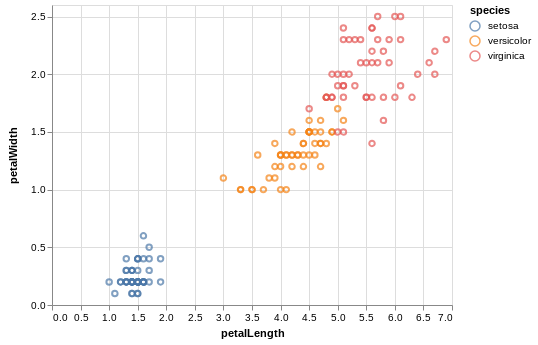

In [77]:
import altair as alt
from vega_datasets import data

iris = data.iris()

alt.Chart(iris).mark_point().encode(
    x='petalLength',
    y='petalWidth',
    color='species'
)